# Feature Transformations

We typically use neural networks (NNs) as a very complex, automated feature extraction. The hope this that the NN will be able to provide a feature representation that allows us to do learning. However, there are some tricky features which require a little bit of preprocessing. These include spatial and temporal (spatio-temporal) features. This notebook will go through some of the ways we can *help* our network by giving some informative features.

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = root.joinpath("experiments/dc_2021b/")

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Argumentsget_data_args

In [3]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"
args.feature_scaler = "standard"

args.smoke_test = False
args.wandb_mode = "disabled"
args.wandb_resume = True

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Transformations

**Coordinates**

* **Latitude**: `-90 =< lat <= 90`
* **Longtiude**: `-180 =< lon <= 180`

* Cartesian/Spherical


**Time**

* Cycle
* 

### Cartesian Coordinates


$$
\begin{aligned}
x &= r \cos(\lambda)\cos(\phi) \\
y &= r \cos(\lambda)\sin(\phi) \\
z &= r \sin(\lambda)
\end{aligned}
$$

where:

* $\phi \in [-90, 90]$ - longitude
* $\lambda \in [-180, 180]$ - latitude
* $r$ - radius

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.pipeline import Pipeline

In [ ]:
from ml4ssh._src.features import Spherical2Cartesian3D, TimeMinMaxScaler

In [ ]:
# create longitude coords
n_points = 100
buffer = 0.001 # to ensure we don't git the boundaries exactly

lon_coords = np.linspace(-(90-buffer), 90 - buffer, n_points)
lat_coords = np.linspace(-(180-buffer), 180-buffer, n_points)

# create grid
lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords)
lon_grid, lat_grid = lon_grid.ravel(), lat_grid.ravel()

assert lon_grid.shape[0] == n_points*n_points
assert lat_grid.shape[0] == n_points*n_points

# create dataframe
data = pd.DataFrame(
    {"longitude": lon_grid,
     "latitude": lat_grid,
    }
)
assert data.shape[0] == n_points*n_points

In [ ]:
lon_grid.shape

In [ ]:
spatial_transform = Pipeline([
    ("cartesian3d", Spherical2Cartesian3D(radius=1.0))
])

spatial_features = ["longitude", "latitude"]

In [ ]:
data_ = spatial_transform.fit_transform(data)
data_.shape

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(data_[:,0], data_[:,1], data_[:, 2], s=1.0)
plt.show()

### Column Transformer

Now we can use this as a part of a `scikit-learn` `pipeline`. This allows us to automate things a little bit.

In [ ]:
scaler = ColumnTransformer(
    transformers=[
        ("cartesian3d", Spherical2Cartesian3D(radius=1.0), spatial_features),
    ],
    remainder="drop",
)

In [ ]:
data_ = scaler.fit_transform(data)

In [ ]:
data_.shape

## Temporal Coordinates

In [ ]:
from ml4ssh._src.features import TimeMinMaxScaler
from sklearn.preprocessing import minmax_scale, MinMaxScaler

In [ ]:
time_coords = np.arange(
    "2010-01-01", 
    "2015-12-31", 
    dtype='datetime64[1h]'
)
df_ts = pd.DataFrame(
    {"time":time_coords}
)


In [ ]:
df_ts.head()

In [ ]:
df_ts.plot()

### Scaling

So, the fourier feature methods and SIREN networks in general, we need to do some sort of scaling of the inputs.

**Absolute Time**

* `t0 = 2005-01-01`
* `t1 = 2022-01-01`

**Absolute Scale**

* `scale_min = -1.0`
* `scale_max = 1.0`

In [ ]:
time_min = np.datetime64("2005-01-01")
time_max = np.datetime64("2022-01-01")
max_scale = 1.0
min_scale = -1.0

In [ ]:
time_std = (time_coords - time_min) / (time_max - time_min)
time_scaled = time_std * (max_scale - min_scale) + min_scale

In [ ]:
time_std

In [ ]:
time_scaled

In [ ]:
class TimeMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        time_min: str=np.datetime64("2005-01-01"),
        time_max: str=np.datetime64("2022-01-01"),
        julian_date: bool=True,
    ):
        self.time_min = time_min
        self.time_max = time_max
        self.julian_date = julian_date
        
        return None
        
    def fit(self, X: pd.DataFrame(), y=None):
        return self

    
    def transform(self, X, y=None):
        
        X = X["time"]
        
        if not self.julian_date:
            
            time_min, time_max = self.time_min, self.time_max
            
        else:
            X = pd.DatetimeIndex(X).to_julian_date().copy()
            
            time_min = pd.DatetimeIndex([self.time_min]).to_julian_date()
            time_max = pd.DatetimeIndex([self.time_max]).to_julian_date()
            
        
        X = (X - time_min) / (time_max - time_min)
        

        return X.values[:, None]

In [ ]:
temporal_transform = Pipeline([
    ("timestd", TimeMinMaxScaler(julian_date=True)),
    ("minmax", MinMaxScaler(feature_range=(-1,1)))
])

temporal_features = ["time"]

In [ ]:
df_ts_ = temporal_transform.fit_transform(df_ts)
df_ts_.shape

In [ ]:
df_ts_

In [ ]:
data_.shape

In [ ]:
data_

## Putting Everything Together

So now, we are going to have a full spatio-temporal vector

$$
\mathbf{x} \in \mathbb{R}^{D_\phi}, \;\;\; D_\phi = \{ \text{lon, lat, time} \}
$$

And we are going to do some transformations on the spatial and temporal features independently.

In [ ]:
# create dataframe
data = pd.DataFrame(
    {"longitude": lon_grid,
     "latitude": lat_grid,
     "time": df_ts.sample(n=lon_grid.shape[0], random_state=1).values[:, 0]
    }
)

In [ ]:
data.head()

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
spatial_features = ["longitude", "latitude"]
temporal_features = ["time"]

In [ ]:
# spatial transform
spatial_transform = Pipeline([
    ("cartesian3d", Spherical2Cartesian3D(radius=1.0))
])

spatial_features = ["longitude", "latitude"]

# temporal transform
temporal_transform = Pipeline([
    ("timestd", TimeMinMaxScaler(julian_date=True)),
    ("minmax", MinMaxScaler(feature_range=(-1,1)))
])

temporal_features = ["time"]

In [ ]:
scaler = ColumnTransformer(
    transformers=[
        ("cartesian3d", spatial_transform, spatial_features),
        ("timeminmax", temporal_transform, temporal_features),
    ],
    remainder="drop",
)

In [ ]:
data_ = scaler.fit_transform(data)

In [ ]:
assert data_.shape[1] == 4

### Cyclic Coordinates

In [ ]:
lon_max = 180
lon_min = -180
min_scale = -1
max_scale = 1

In [94]:

lon_std = (lon_coords - lon_min) / (lon_max - lon_min)
lon_coords_scaled = lon_std * (max_scale - min_scale) + min_scale
lon_coords_scaled.min(), lon_coords_scaled.max()

(-1.0, 1.0)

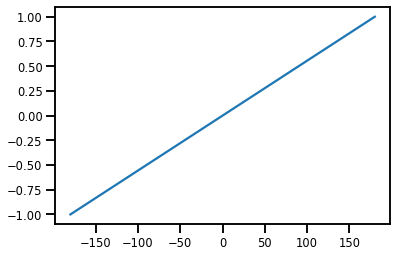

In [95]:
fig, ax = plt.subplots()
ax.plot(lon_coords, lon_coords_scaled)
plt.show()

In [96]:
# scale between 
lon_coords_scaled_sin = np.sin(np.pi * lon_coords_scaled)
lon_coords_scaled_cos = np.cos(np.pi * lon_coords_scaled)

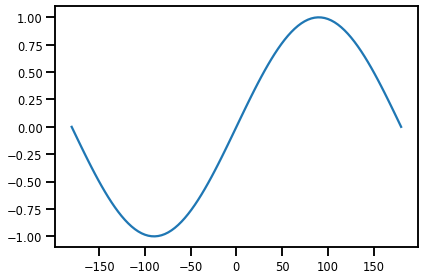

In [97]:
fig, ax = plt.subplots()
ax.plot(lon_coords, lon_coords_scaled_sin)
plt.tight_layout()
plt.show()

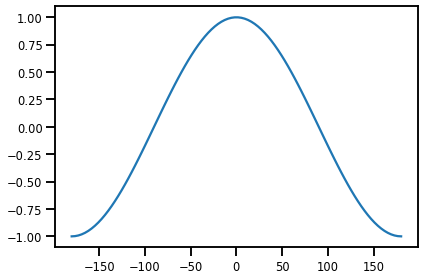

In [98]:
fig, ax = plt.subplots()
ax.plot(lon_coords, lon_coords_scaled_cos)
plt.tight_layout()
plt.show()

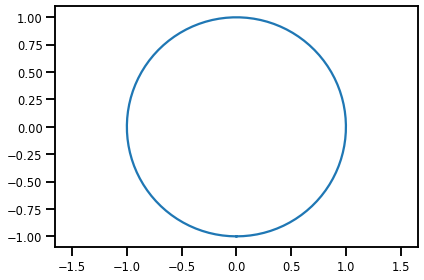

In [99]:
fig, ax = plt.subplots()
ax.plot(lon_coords_scaled_sin, lon_coords_scaled_cos)
plt.tight_layout()
plt.axis("equal")
plt.show()